In [1]:
import re
import pandas as pd

def extract_songs_from_database(file_path):
    
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    
    def extract_single_bpm(content):
        content = content.strip()
        
        if '/' in content or '-' in content:
            numbers = re.findall(r'(\d+(?:\.\d+)?)', content)
            if numbers:
                first_bpm = int(float(numbers[0]))
                if 30 <= first_bpm <= 400:
                    return first_bpm
        

        bpm_match = re.search(r'~?(\d+(?:\.\d+)?)', content.strip())
        if bpm_match:
            bpm_value = int(float(bpm_match.group(1)))
            if bpm_value > 300:
                half_bpm = bpm_value // 2
                if 60 <= half_bpm <= 200:  
                    return half_bpm
            return bpm_value
        return None

    def is_bpm_content(content):
        content = content.strip()
        
        if not re.match(r'^~?\d+(?:\.\d+)?(?:[/-]~?\d+(?:\.\d+)?)*$', content):
            return False
        
        if '/' in content or '-' in content:
            numbers = re.findall(r'(\d+(?:\.\d+)?)', content)
            if numbers:
                first_number = numbers[0]
            else:
                return False
        else:
            first_number_match = re.search(r'~?(\d+(?:\.\d+)?)', content)
            if not first_number_match:
                return False
            first_number = first_number_match.group(1)
        
        if not is_realistic_bpm(first_number):
            return False
        
        if is_likely_year(first_number) and contains_year_indicators(content):
            return False
        
        if len(first_number) == 4 and 2000 <= float(first_number) <= 2030:
            return False
        
        return True
    
    def is_realistic_bpm(value):
        try:
            bpm = float(value)
            return 30 <= bpm <= 400
        except (ValueError, TypeError):
            return False
    
    def contains_year_indicators(content):
        content_lower = content.lower()
        year_indicators = [
            'released', 'album', 'year', 'born', 'century', 'edition', 
            'version', 'remaster', 'recorded', 'live', 'remix', 'edit',
            'ep', 'lp', 'single', 'compilation', 'soundtrack'
        ]
        return any(indicator in content_lower for indicator in year_indicators)
    
    def is_likely_year(value):
        try:
            num = float(value)
            return 1950 <= num <= 2030
        except (ValueError, TypeError):
            return False
    
    def is_tuning_info(content):
        return bool(re.search(r'^[+-]\d+$', content.strip()))
    
    def contains_multiple_parentheses_with_bpm(parentheses_list):
        bpm_candidates = []
        other_content = []
        
        for content in parentheses_list:
            content = content.strip()
            if not content:
                continue
                
            if is_bpm_content(content):
                bpm_candidates.append(content)
            else:
                other_content.append(content)

        return bpm_candidates, other_content
    
    key_pattern = re.compile(r'^\[(.+?)\]$', re.MULTILINE)
    keys = [(m.start(), m.group(1)) for m in key_pattern.finditer(text)]
    keys.append((len(text), None))
    
    songs_data = []
    
    for i in range(len(keys) - 1):
        start, section_key = keys[i]
        end, _ = keys[i + 1]
        section_text = text[start:end]
        
        song_lines = re.findall(r'• .+', section_text)
        
        for line in song_lines:
            line = line[2:].strip()
            
            if ' - ' not in line:
                continue
            
            artist_part, rest = line.split(' - ', 1)
            artist = artist_part.strip()
            
            parentheses_content = re.findall(r'\(([^)]*)\)', rest)
            
            song_title = re.sub(r'\s*\([^)]*\)', '', rest).strip()
            
            bpm = None
            notes = []
            
            if parentheses_content:
                bpm_candidates, other_content = contains_multiple_parentheses_with_bpm(parentheses_content)
                
                for bpm_candidate in bpm_candidates:
                    if bpm is None:
                        if not (contains_year_indicators(bpm_candidate) and is_likely_year(extract_single_bpm(bpm_candidate))):
                            bpm = extract_single_bpm(bpm_candidate)
                            if '/' in bpm_candidate or '~' in bpm_candidate or '.' in bpm_candidate:
                                notes.append(f"BPM: {bpm_candidate}")
                        else:
                            other_content.append(bpm_candidate)
                
                for content in other_content:
                    if not is_tuning_info(content) and content.strip():
                        notes.append(content)
            
            if bpm is None and parentheses_content:
                for content in parentheses_content:
                    content = content.strip()
                    if not content:
                        continue
                    
                    numeric_match = re.search(r'(\d+)', content)
                    if numeric_match:
                        potential_bpm = int(numeric_match.group(1))
                        if 40 <= potential_bpm <= 300 and not (2000 <= potential_bpm <= 2030):
                            bpm = potential_bpm
                            notes.append(f"BPM: {content}")
                            break

            notes_str = "; ".join(notes) if notes else ""

            songs_data.append([artist, song_title, bpm if bpm else "", section_key, notes_str])

    return pd.DataFrame(songs_data, columns=["Artist", "Song", "BPM", "Key", "Notes"])

df_final = extract_songs_from_database("Duuzu Song Key & BPM Database v10.txt")

print(f"Successfully extracted {len(df_final)} songs from the database!")
print(f"\nDataFrame shape: {df_final.shape}")
print(f"Columns: {list(df_final.columns)}")

print(f"\nData completeness:")
print(f"- Songs with BPM: {(df_final['BPM'] != '').sum()}")
print(f"- Songs with notes: {(df_final['Notes'] != '').sum()}")

print("\nFirst 10 entries:")
print(df_final.head(10).to_string(index=False))

Successfully extracted 19055 songs from the database!

DataFrame shape: (19055, 5)
Columns: ['Artist', 'Song', 'BPM', 'Key', 'Notes']

Data completeness:
- Songs with BPM: 18828
- Songs with notes: 12998

First 10 entries:
                                      Artist                                                                                   Song BPM  Key                                                                          Notes
        ⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet) ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙͚͜͢͢͢͢͢͢͢͢͢͢͢͢͢͢ͅ ఠీੂ೧ູ࿃ूੂ✧ළʅ͡͡͡͡͡͡͡͡͡͡͡ 128 Amin ƪ❍⊁◞..◟⊀ ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙͚͜͢͢͢͢͢͢͢͢͢͢͢͢͢͢ͅ (inst
        ⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet)                                                                vȯ)) ̷̨ʅ:::̵̳̗̊vȯ)) ̷̨ʅ 129 Amin                                                 ۝ʅ(Ɵʅ(; Ɵʅ(; i've got feelings
                                    100 gecs                                                                         

In [2]:
df_final

,Artist,Song,BPM,Key,Notes
0,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙...,128,Amin,ƪ❍⊁◞..◟⊀ ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈...
1,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),vȯ)) ̷̨ʅ:::̵̳̗̊vȯ)) ̷̨ʅ,129,Amin,۝ʅ(Ɵʅ(; Ɵʅ(; i've got feelings
2,100 gecs,geccraft,84,Amin,BPM: 84.5/169
3,100 gecs,money machine,99,Amin,umru remix; drake - forever
4,2 Mello,BREAK DOWN BREAK UP,144,Amin,Ablues
...,...,...,...,...,...
19050,Splatoon 3,Octoplush - Don't Flinch,90,other,"BPM: 90/180; some Emin, some Cmaj , some C#maj"
19051,"Tyler, The Creator ft. Lil Wayne & Kanye West",SMUCKERS,80,other,"BPM: 80/160; +40, key constantly changing, som..."
19052,Uffie,Hot Chick,128,other,phr; key constantly changing
19053,UNDERTALE,Toby Fox - Chill,,other,chords are Bmaj7 Gmaj7 C#maj7 Emaj7 Amaj7 Dmaj...


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def analyze_statistics(df): 
    print(f"Dataset Overview:")
    print(f"- Total songs: {len(df):,}")
    print(f"- Columns: {list(df.columns)}")
    
    print(f"\nBPM ANALYSIS:")
    print("-" * 40)
    
    songs_with_bpm = df[df['BPM'] != '']
    songs_without_bpm = df[df['BPM'] == '']
    
    print(f"Songs with BPM: {len(songs_with_bpm):,} ({len(songs_with_bpm)/len(df)*100:.1f}%)")
    print(f"Songs without BPM: {len(songs_without_bpm):,} ({len(songs_without_bpm)/len(df)*100:.1f}%)")
    
    if len(songs_with_bpm) > 0:
        bpm_numeric = pd.to_numeric(songs_with_bpm['BPM'], errors='coerce')
        
        print(f"\nBPM Statistics (for songs with BPM):")
        print(f"- Minimum BPM: {bpm_numeric.min()}")
        print(f"- Maximum BPM: {bpm_numeric.max()}")
        print(f"- Average BPM: {bpm_numeric.mean():.1f}")
        print(f"- Median BPM: {bpm_numeric.median():.1f}")
        print(f"- Standard Deviation: {bpm_numeric.std():.1f}")

        print(f"\nBPM Distribution:")
        print(f"- 25th percentile: {bpm_numeric.quantile(0.25):.1f}")
        print(f"- 75th percentile: {bpm_numeric.quantile(0.75):.1f}")
        print(f"- Interquartile Range: {bpm_numeric.quantile(0.75) - bpm_numeric.quantile(0.25):.1f}")
        
        print(f"\nTop 10 Most Common BPM Values:")
        bpm_counts = bpm_numeric.value_counts().head(10)
        for bpm, count in bpm_counts.items():
            print(f"  {bpm} BPM: {count} songs ({count/len(songs_with_bpm)*100:.1f}%)")
    
    print(f"\nKEY ANALYSIS:")
    print("-" * 40)
    
    unique_keys = df['Key'].nunique()
    print(f"Number of unique keys: {unique_keys}")
    
    print(f"\nKey Distribution (Top 15):")
    key_counts = df['Key'].value_counts().head(15)
    for key, count in key_counts.items():
        print(f"  {key}: {count} songs ({count/len(df)*100:.1f}%)")
    
    print(f"\nNOTES ANALYSIS:")
    print("-" * 40)
    songs_with_notes = df[df['Notes'] != '']
    print(f"Songs with notes: {len(songs_with_notes):,} ({len(songs_with_notes)/len(df)*100:.1f}%)")
    
    return {
        'total_songs': len(df),
        'songs_with_bpm': len(songs_with_bpm),
        'songs_without_bpm': len(songs_without_bpm),
        'unique_keys': unique_keys,
        'songs_with_notes': len(songs_with_notes),
        'bpm_stats': bpm_numeric.describe() if len(songs_with_bpm) > 0 else None,
        'key_distribution': key_counts
    }

stats_summary = analyze_statistics(df_final)

Dataset Overview:
- Total songs: 19,055
- Columns: ['Artist', 'Song', 'BPM', 'Key', 'Notes']

BPM ANALYSIS:
----------------------------------------
Songs with BPM: 18,828 (98.8%)
Songs without BPM: 227 (1.2%)

BPM Statistics (for songs with BPM):
- Minimum BPM: 37
- Maximum BPM: 256
- Average BPM: 111.4
- Median BPM: 115.0
- Standard Deviation: 23.4

BPM Distribution:
- 25th percentile: 91.0
- 75th percentile: 129.0
- Interquartile Range: 38.0

Top 10 Most Common BPM Values:
  128 BPM: 873 songs (4.6%)
  120 BPM: 823 songs (4.4%)
  130 BPM: 728 songs (3.9%)
  140 BPM: 586 songs (3.1%)
  125 BPM: 565 songs (3.0%)
  80 BPM: 563 songs (3.0%)
  100 BPM: 550 songs (2.9%)
  90 BPM: 537 songs (2.9%)
  85 BPM: 409 songs (2.2%)
  95 BPM: 340 songs (1.8%)

KEY ANALYSIS:
----------------------------------------
Number of unique keys: 25

Key Distribution (Top 15):
  Emin: 1378 songs (7.2%)
  Amin: 1349 songs (7.1%)
  Cmin: 1339 songs (7.0%)
  Dmin: 1253 songs (6.6%)
  Gmin: 1026 songs (5.4%)
  F

In [4]:
unique_keys_count = df_final['Key'].nunique()
print(f"Number of unique keys: {unique_keys_count}")

print(f"\nAll unique keys:")
unique_keys = sorted(df_final['Key'].unique())
for key in unique_keys:
    print(f"- {key}")

Number of unique keys: 25

All unique keys:
- A#min
- Abmaj
- Amaj
- Amin
- Bbmaj
- Bmaj
- Bmin
- C#maj
- C#min
- Cmaj
- Cmin
- D#min
- Dmaj
- Dmin
- Ebmaj
- Emaj
- Emin
- F#maj
- F#min
- Fmaj
- Fmin
- G#min
- Gmaj
- Gmin
- other


In [5]:
song_without_bpm = df_final[df_final['BPM'] == '']
song_without_bpm

,Artist,Song,BPM,Key,Notes
50,Arca,????? A pt1,,Amin,
95,Bill Conti,Gonna Fly Now,,Amin,Rocky Theme
105,Björk,Cover Me,,Amin,"Adr, some Aharm"
354,DJ Shadow,Best Foot Forward,,Amin,
572,"Jack Ü, Skrillex, Diplo",Don't Do Drugs Just Take Some Jack Ü,,Amin,Adr
...,...,...,...,...,...
18895,Minecraft,C418 - Floating Trees,,Bmaj,menu4.ogg; Blyd; end is G#min
18922,Pharrell Williams,I Really Like You,,Bmaj,"Bblues with C#min F#maj Bmin Emaj, chorus is C..."
18954,Rhythm Heaven Fever,,,Bmaj,"Masami Yone, Shinji Ushiroda, Asuka Ito - Remi..."
18986,Super Mario Sunshine,Casino Fanfair,,Bmaj,Bmx


In [6]:
df_clean = df_final[df_final['BPM'] != '']
df_clean

,Artist,Song,BPM,Key,Notes
0,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙...,128,Amin,ƪ❍⊁◞..◟⊀ ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈...
1,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),vȯ)) ̷̨ʅ:::̵̳̗̊vȯ)) ̷̨ʅ,129,Amin,۝ʅ(Ɵʅ(; Ɵʅ(; i've got feelings
2,100 gecs,geccraft,84,Amin,BPM: 84.5/169
3,100 gecs,money machine,99,Amin,umru remix; drake - forever
4,2 Mello,BREAK DOWN BREAK UP,144,Amin,Ablues
...,...,...,...,...,...
19049,Splatoon 3,Medusa - Clashing Colors,150,other,D# in bass but otherwise idk
19050,Splatoon 3,Octoplush - Don't Flinch,90,other,"BPM: 90/180; some Emin, some Cmaj , some C#maj"
19051,"Tyler, The Creator ft. Lil Wayne & Kanye West",SMUCKERS,80,other,"BPM: 80/160; +40, key constantly changing, som..."
19052,Uffie,Hot Chick,128,other,phr; key constantly changing


BPM Analysis:
Total songs with BPM: 18828
BPM data type: object

BPM Range:
Minimum BPM: 37
Maximum BPM: 256
Average BPM: 111.4
Median BPM: 115.0

BPM Distribution:
25th percentile: 91.0
75th percentile: 129.0

Top 10 most common BPM values:
BPM
128    873
120    823
130    728
140    586
125    565
80     563
100    550
90     537
85     409
95     340
Name: count, dtype: int64


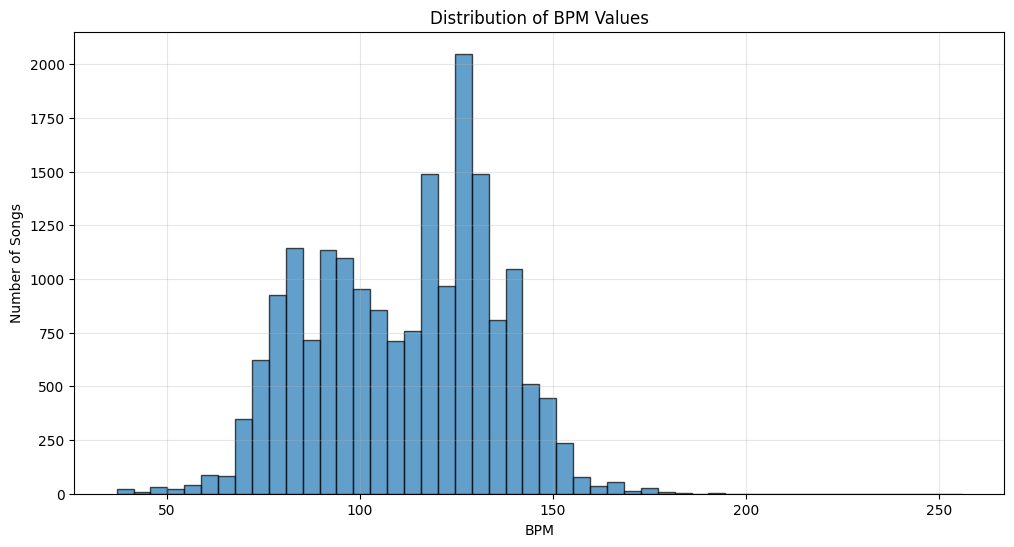

In [7]:
print("BPM Analysis:")
print(f"Total songs with BPM: {len(df_clean)}")
print(f"BPM data type: {df_clean['BPM'].dtype}")

bpm_numeric = pd.to_numeric(df_clean['BPM'], errors='coerce')

print(f"\nBPM Range:")
print(f"Minimum BPM: {bpm_numeric.min()}")
print(f"Maximum BPM: {bpm_numeric.max()}")
print(f"Average BPM: {bpm_numeric.mean():.1f}")
print(f"Median BPM: {bpm_numeric.median():.1f}")

print(f"\nBPM Distribution:")
print(f"25th percentile: {bpm_numeric.quantile(0.25):.1f}")
print(f"75th percentile: {bpm_numeric.quantile(0.75):.1f}")

print(f"\nTop 10 most common BPM values:")
print(bpm_numeric.value_counts().head(10))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(bpm_numeric.dropna(), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('BPM')
plt.ylabel('Number of Songs')
plt.title('Distribution of BPM Values')
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
def convert_key_to_camelot(df):
    key_to_camelot = {
        # Major keys (B = major)
        'Cmaj': '8B', 'C#maj': '3B', 'Dbmaj': '3B',
        'Dmaj': '10B', 'D#maj': '5B', 'Ebmaj': '5B',
        'Emaj': '12B', 'Fmaj': '7B',
        'F#maj': '2B', 'Gbmaj': '2B',
        'Gmaj': '9B', 'G#maj': '4B', 'Abmaj': '4B',
        'Amaj': '11B', 'A#maj': '6B', 'Bbmaj': '6B',
        'Bmaj': '1B',
        
        # Minor keys (A = minor)
        'Amin': '8A', 'A#min': '3A', 'Bbmin': '3A',
        'Bmin': '10A', 'Cmin': '5A',
        'C#min': '12A', 'Dbmin': '12A',
        'Dmin': '7A', 'D#min': '2A', 'Ebmin': '2A',
        'Emin': '9A', 'Fmin': '4A',
        'F#min': '11A', 'Gbmin': '11A',
        'Gmin': '6A', 'G#min': '1A', 'Abmin': '1A',
        
        # Handle variations and edge cases
        'other': '0X'  # Special case for unknown keys
    }
    
    return df['Key'].map(key_to_camelot)

def convert_key_to_scalar(df):
    camelot_to_scalar = {
        # Minor keys (A) - inner wheel (0-11)
        '1A': 0, '2A': 1, '3A': 2, '4A': 3, '5A': 4, '6A': 5,
        '7A': 6, '8A': 7, '9A': 8, '10A': 9, '11A': 10, '12A': 11,
        
        # Major keys (B) - outer wheel (12-23)
        '1B': 12, '2B': 13, '3B': 14, '4B': 15, '5B': 16, '6B': 17,
        '7B': 18, '8B': 19, '9B': 20, '10B': 21, '11B': 22, '12B': 23,
        
        '0X': 24  # Unknown keys
    }

    return df['Key'].map(camelot_to_scalar)

df_clean['Key'] = convert_key_to_camelot(df_clean)
key_scalars = convert_key_to_scalar(df_clean)
df_clean['Key_Scalar'] = key_scalars

df_clean = df_clean.reset_index(drop=True)
try:
    df_clean.insert(0, 'ID', range(1, len(df_clean) + 1))
except Exception as e:
    print(f"Error adding ID column: {e}")

print(f"Added Camelot wheel support. DataFrame now has {len(df_clean)} songs with IDs 1-{len(df_clean)}")
print("\nSample of Camelot key mappings:")
print(df_clean[['ID', 'Artist', 'Song', 'Key', 'Key', 'Key_Scalar', 'BPM']].head(10))

Added Camelot wheel support. DataFrame now has 18828 songs with IDs 1-18828

Sample of Camelot key mappings:
   ID                                        Artist  \
0   1          ⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet)   
1   2          ⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet)   
2   3                                      100 gecs   
3   4                                      100 gecs   
4   5                                       2 Mello   
5   6                      21 Savage & Metro Boomin   
6   7                                  3 Doors Down   
7   8                                           +44   
8   9                                    A. G. Cook   
9  10  A. G. Cook ft. Sarah Bonito & Hannah Diamond   

                                                Song Key Key  Key_Scalar  BPM  
0  ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙...  8A  8A           7  128  
1                            vȯ)) ̷̨ʅ:::̵̳̗̊vȯ)) ̷̨ʅ  8A  8A           7  129  
2                                           g

/var/folders/b0/d4yy08y16hgb08jzh8jd4lh80000gn/T/ipykernel_32584/1916205503.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Key'] = convert_key_to_camelot(df_clean)
/var/folders/b0/d4yy08y16hgb08jzh8jd4lh80000gn/T/ipykernel_32584/1916205503.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Key_Scalar'] = key_scalars


In [9]:
df_clean

,ID,Artist,Song,BPM,Key,Notes,Key_Scalar
0,1,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈͇͉͍͎͓͔͕͖͙...,128,8A,ƪ❍⊁◞..◟⊀ ̟̞̝̜̙̘̗̖҉̵̴̨̧̢̡̼̻̺̹̳̲̱̰̯̮̭̬̫̪̩̦̥̤̣̠҈͈...,7
1,2,⣎⡇ꉺლ༽இ•̛)ྀ◞ ༎ຶ ༽ৣৢ؞ৢ؞ؖ ꉺლ (Four Tet),vȯ)) ̷̨ʅ:::̵̳̗̊vȯ)) ̷̨ʅ,129,8A,۝ʅ(Ɵʅ(; Ɵʅ(; i've got feelings,7
2,3,100 gecs,geccraft,84,8A,BPM: 84.5/169,7
3,4,100 gecs,money machine,99,8A,umru remix; drake - forever,7
4,5,2 Mello,BREAK DOWN BREAK UP,144,8A,Ablues,7
...,...,...,...,...,...,...,...
18823,18824,Splatoon 3,Medusa - Clashing Colors,150,0X,D# in bass but otherwise idk,24
18824,18825,Splatoon 3,Octoplush - Don't Flinch,90,0X,"BPM: 90/180; some Emin, some Cmaj , some C#maj",24
18825,18826,"Tyler, The Creator ft. Lil Wayne & Kanye West",SMUCKERS,80,0X,"BPM: 80/160; +40, key constantly changing, som...",24
18826,18827,Uffie,Hot Chick,128,0X,phr; key constantly changing,24


In [10]:
df_clean.to_csv("duuzu_song_database_cleaned.csv", index=False)

/var/folders/b0/d4yy08y16hgb08jzh8jd4lh80000gn/T/ipykernel_32584/3310054235.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='Key', y='BPM', data=df, order=key_order, jitter=0.25,


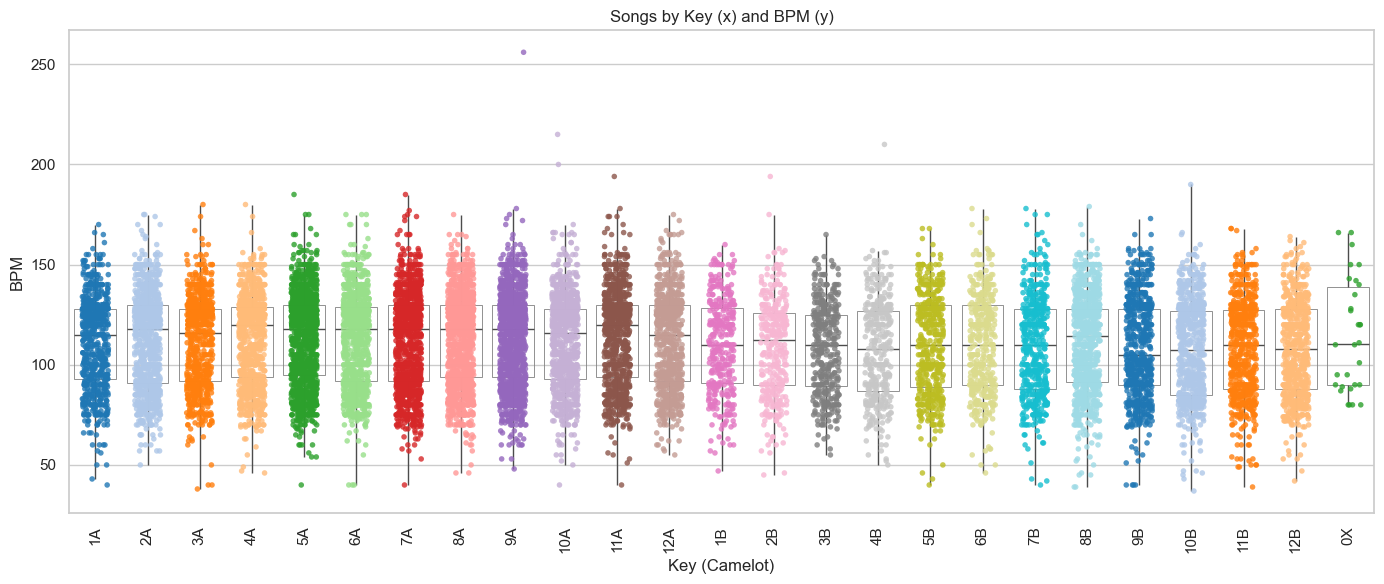

In [11]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "duuzu_song_database_cleaned.csv" 

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found in current folder")

df = pd.read_csv(csv_path)
df['BPM'] = pd.to_numeric(df['BPM'], errors='coerce')
df = df.dropna(subset=['BPM', 'Key']).copy()

if 'Key_Scalar' in df.columns:
    key_order = df.groupby('Key')['Key_Scalar'].mean().sort_values().index.tolist()
else:
    key_order = sorted(df['Key'].unique())

plt.figure(figsize=(14,6))
sns.set(style="whitegrid")

sns.boxplot(x='Key', y='BPM', data=df, order=key_order,
            showcaps=False, boxprops={'facecolor':'none', 'edgecolor':'gray', 'linewidth':0.6},
            showfliers=False)

sns.stripplot(x='Key', y='BPM', data=df, order=key_order, jitter=0.25,
              palette=sns.color_palette("tab20", n_colors=len(key_order)), size=4, alpha=0.8)

plt.xticks(rotation=90)
plt.xlabel("Key (Camelot)")
plt.ylabel("BPM")
plt.title("Songs by Key (x) and BPM (y)")
plt.tight_layout()

plt.savefig("bpm_by_key_scatter.png", dpi=200, bbox_inches='tight')
plt.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("duuzu_song_database_cleaned.csv")
df['BPM'] = pd.to_numeric(df['BPM'], errors='coerce')

print("\nSONGS BY KEY (Camelot Wheel):")
print("-" * 40)
key_counts = df['Key'].value_counts().sort_index()
for key, count in key_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{key:4s}: {count:4d} songs ({percentage:5.1f}%)")

print(f"\nTotal unique keys: {df['Key'].nunique()}")
print(f"Most common key: {key_counts.index[0]} ({key_counts.iloc[0]} songs)")
print(f"Least common key: {key_counts.index[-1]} ({key_counts.iloc[-1]} songs)")

print("\n\nSONGS BY BPM RANGES:")
print("-" * 40)

bpm_ranges = [
    (0, 70, "Very Slow (0-70)"),
    (71, 90, "Slow (71-90)"),
    (91, 110, "Medium-Slow (91-110)"),
    (111, 130, "Medium (111-130)"),
    (131, 150, "Medium-Fast (131-150)"),
    (151, 170, "Fast (151-170)"),
    (171, 200, "Very Fast (171-200)"),
    (201, 300, "Extremely Fast (201-300)"),
    (301, 500, "Ultra Fast (301+)")
]

bpm_distribution = []
for min_bpm, max_bpm, label in bpm_ranges:
    count = len(df[(df['BPM'] >= min_bpm) & (df['BPM'] <= max_bpm)])
    percentage = (count / len(df)) * 100
    bpm_distribution.append((label, count, percentage))
    print(f"{label:20s}: {count:4d} songs ({percentage:5.1f}%)")



SONGS BY KEY (Camelot Wheel):
----------------------------------------
0X  :   30 songs (  0.2%)
10A :  930 songs (  4.9%)
10B :  718 songs (  3.8%)
11A :  870 songs (  4.6%)
11B :  652 songs (  3.5%)
12A :  823 songs (  4.4%)
12B :  663 songs (  3.5%)
1A  :  699 songs (  3.7%)
1B  :  364 songs (  1.9%)
2A  :  938 songs (  5.0%)
2B  :  368 songs (  2.0%)
3A  :  750 songs (  4.0%)
3B  :  378 songs (  2.0%)
4A  :  993 songs (  5.3%)
4B  :  381 songs (  2.0%)
5A  : 1320 songs (  7.0%)
5B  :  484 songs (  2.6%)
6A  : 1018 songs (  5.4%)
6B  :  429 songs (  2.3%)
7A  : 1242 songs (  6.6%)
7B  :  483 songs (  2.6%)
8A  : 1338 songs (  7.1%)
8B  :  942 songs (  5.0%)
9A  : 1354 songs (  7.2%)
9B  :  661 songs (  3.5%)

Total unique keys: 25
Most common key: 0X (30 songs)
Least common key: 9B (661 songs)


SONGS BY BPM RANGES:
----------------------------------------
Very Slow (0-70)    :  492 songs (  2.6%)
Slow (71-90)        : 4097 songs ( 21.8%)
Medium-Slow (91-110): 4093 songs ( 21.7%)
M